In [1]:
# import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

from scipy.stats import wilcoxon

import pickle
from pprint import pprint

# Data Loading

In [2]:
# Load data
output = pickle.load(open("experiment_results.pickle", "rb"))
output_top91 = pickle.load(open("experiment_results_top91.pickle", "rb"))

output.update(output_top91)

# Files in scope
for file_name in output:
    print("File:", file_name, ", #sudokus:", len(output[file_name]))

File: 100_easy_sudokus , #sudokus: 100
File: damnhard.sdk , #sudokus: 35
File: top91.sdk , #sudokus: 91


In [9]:
# Show heuristics performance on selected variables

def get_heuristics_metrics_data(heuristics, biased = False):
    df = pd.DataFrame(columns=["backtracks",
                                        "flips",
                                        "var_picks",
                                        "simplifications",
                                        "heuristic",
                                        "biased_coin",
                                        "bit_length",
                                        "mean_compression",
                                        "file_name"])
    for file_name in output:
        for sudoku_id in output[file_name]:
            for heuristic in heuristics:
                df = df.append({
                    "backtracks":float(output[file_name][sudoku_id][(heuristic, biased)]["number_of_backtracks"]), 
                    "flips": float(output[file_name][sudoku_id][(heuristic, biased)]["number_of_flips"]),
                    "var_picks": float(output[file_name][sudoku_id][(heuristic, biased)]["number_of_var_picks"]),
                    "simplifications": float(output[file_name][sudoku_id][(heuristic, biased)]["simplifications"]),
                    "heuristic": str(heuristic),
                    "biased_coin": str(biased),
                    "bit_length": float(output[file_name][sudoku_id]["entropy"]),
                    "mean_compression": np.mean(output[file_name][sudoku_id]["min_compression"]),
                    "file_name": str(file_name)
                }, ignore_index=True) 
                
    # Transform to log
    df["log_backtracks"] = np.log(df["backtracks"] + 1)
    df["log_flips"] = np.log(df["flips"] + 1)
    df["flips_ratio"] = df["flips"] / (df["backtracks"] + 1)
    df["norm_simplifications"] = df["simplifications"] / (df["backtracks"] + 1)
    df["log_var_picks"] = np.log(df["var_picks"] + 1)
    df["log_norm_simplifications"] = np.log((df["simplifications"] / (df["backtracks"] + 1)) + 1)
                
    return df

In [10]:
heuristics = [None, "MOM", "literalcount", "Jeroslow"]
df_unbiased = get_heuristics_metrics_data(heuristics, biased = False)

# Heuristics effect

In [11]:
def boxplot_heuristics(metric):
    plt.figure(figsize=(10,5))
    sns.boxplot(y="heuristic",
                x=metric,
                hue="file_name",
                showfliers=False,
                palette="Blues",
                data=df_unbiased)
    plt.legend(loc=9, bbox_to_anchor=(1.15, 0.6))

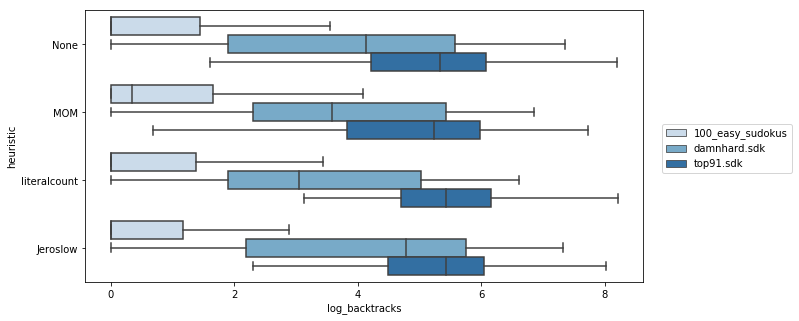

In [12]:
boxplot_heuristics("log_backtracks")
plt.savefig("./images/heuristics_backtracks.eps" , bbox_inches='tight')
plt.show()

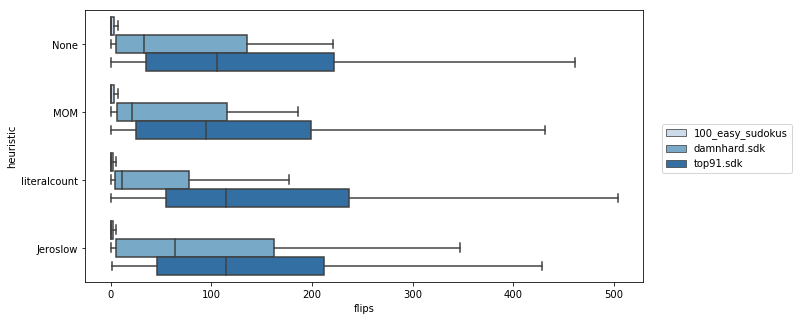

In [20]:
boxplot_heuristics("log_norm_simplifications")
plt.savefig("./images/heuristics_norm_simplifications.eps" , bbox_inches='tight')
plt.show()

# Biased Coin Effect

In [14]:
# Check for importance of biased coin
df_biased = get_heuristics_metrics_data(heuristics, biased = True)    

In [9]:
def plot_biased_boxplot(heuristic, metric):
    print("-"*50)
    print(heuristic, metric, "\n")
    
    # Concatenate data
    df_compare_bias = pd.concat([df_unbiased, df_biased])
    
    #subselect data
    df_compare_bias = df_compare_bias.loc[(df_compare_bias["heuristic"] == str(heuristic))]
    
    plt.figure(figsize=(10,5))
    ax = sns.boxplot(y=metric, x="biased_coin", showfliers=False, orient = "v", data=df_compare_bias)
    add_stat_annotation(ax, data=df_compare_bias, y=metric, x="biased_coin",
                    boxPairList=[("False", "True")],
                    test='t-test_ind', textFormat='star', loc='outside', verbose=2)

    plt.show()


def plot_biased_distribution(heuristic, metric):
    #subselect data
    df_heuristic_biased = df_biased.loc[(df_biased["heuristic"] == str(heuristic))]
    df_heuristic_unbiased = df_unbiased.loc[(df_unbiased["heuristic"] == str(heuristic))]

    #plot
    sns.kdeplot(df_heuristic_biased[metric], label = "biased")
    sns.kdeplot(df_heuristic_unbiased[metric], label = "unbiased")

    plt.legend(loc=0)    

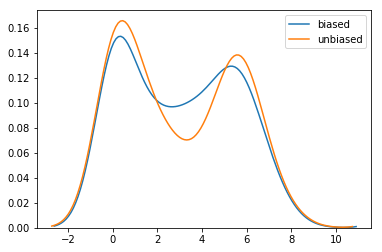

In [10]:
heuristic = "Jeroslow"
log_metric = "log_backtracks"
plot_biased_distribution(heuristic, log_metric)
plt.savefig("./images/biased_coin_Jeroslow.eps" , bbox_inches='tight')
plt.show()

In [11]:
# Non-parametric test
metric = "backtracks"
biased_array = df_biased[[metric]].values.squeeze()
unbiased_array = df_unbiased[[metric]].values.squeeze()
_, p_value = wilcoxon(unbiased_array, biased_array)

print("The p-value for this test:", p_value)
if p_value > 0.05:
    print("We cannot reject the null hypothesis!")
else:
    print("We can reject the null hypothesis")

The p-value for this test: 0.17993771
We cannot reject the null hypothesis!


### Compression Effect

- Pick a heuristic
- Pick a biased_coin
- Plot compression metrics against file_name

In [17]:
flatui = ["#ff8e38", "#3498db", "#95a5a6"]
sns.set_palette(flatui)

def plot_compression_with_file(heuristic, metric):
    plt.figure(figsize=(10,5))
    df_compression = df_biased
    df_compression = df_compression.loc[(df_compression["heuristic"] == str(heuristic))]
    ax = sns.boxplot(y=metric, x="file_name", showfliers=False, orient = "v",
                    palette = flatui , data=df_compression)
    add_stat_annotation(ax, data=df_compression, y=metric, x="file_name",
                    boxPairList=[("100_easy_sudokus", "damnhard.sdk"),
                                 ("100_easy_sudokus", "top91.sdk"),
                                 ("damnhard.sdk", "top91.sdk")],
                    test='t-test_ind',
                    textFormat='star',
                    loc='outside',
                    fontsize = "xx-large",
                    verbose=0)  

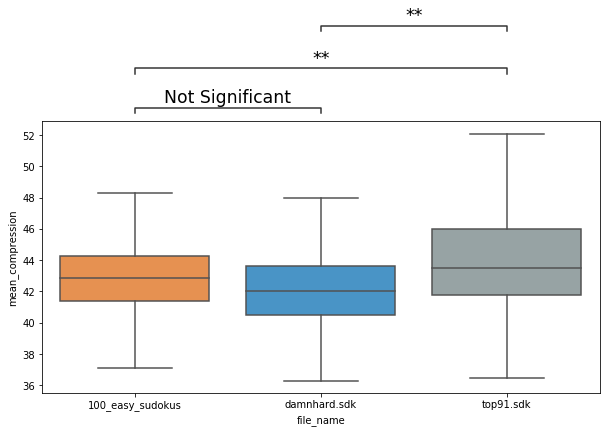

In [18]:
heuristic = "Jeroslow"
metric = "mean_compression"
plot_compression_with_file(heuristic, metric)
plt.savefig("./images/compression_hypothesis_test.eps" , bbox_inches='tight')
plt.show()

- Plot correlation of metrics against mean_compression


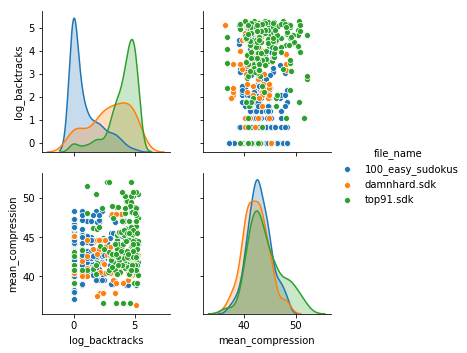

In [123]:
compression_metric = ["mean_compression"]
performance_metrics = ["log_backtracks"]
interesting_columns = performance_metrics + compression_metric

sns.pairplot(df_biased[df_biased['backtracks'] <= 200], vars=interesting_columns, hue = "file_name")
plt.show()

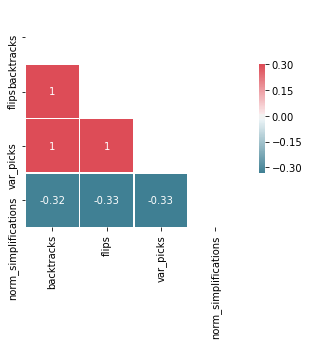

In [15]:
# Compute the correlation matrix
metrics =["backtracks", "flips", "var_picks", "norm_simplifications"]
corr = df_biased[metrics].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}
           )

plt.savefig("./images/variable_selection.eps" , bbox_inches='tight')
plt.show()


# TODOs
- Show correlation of metrics - Done
- Pick two metrics - backtracks and var_picks
- Show heuristics plot for a single metric - Done
- Pick a metric - backtracks
- Pick a heuristic - Jeroslow, justified by complexity
- Show boxplot for biased coin - Done
- Statistical Test - Done
- Pick a biased coin - False for keeping with the original papers
- Show compression results - Done

